> **NeuroFlow Project**
>
> Zhao Ma
>
> 6/3/2019

# Neuroflow: Tracking Patient Progress 

In [664]:
#Import dependencies and packages for analysis
import pandas as pd #pandas has very useful data structures
import numpy as np #numpy supports pandas
import seaborn as sns #seaborn for visualization
import matplotlib.pyplot as plt #matplotlib for plotting
import matplotlib.dates as mdates
from IPython.display import display, HTML
import datetime as dt


### Introduction

Patient progress is difficult to evaluate. With Neuroflow's innovative app, patients can now submit logs about how they feel throughout the day. The question is, what can patients and providers do with this data and what can they learn from it? 

*Goal*: To visualize progress for patients and providers through four metrics: 
- Mood
- Sleep
- Rumination
- Stress


#### What does the data look like?

In [665]:
mood = pd.read_csv('./data/mood.csv')
rumination = pd.read_csv('./data/ruminatory_stress.csv')
sleep = pd.read_csv('./data/sleep.csv')
stress = pd.read_csv('./data/stress.csv')

In [666]:
display(mood.info())
display(rumination.info()) #sleep and stress have the same number (29) of entries as rumination

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
date     56 non-null int64
value    56 non-null int64
dtypes: int64(2)
memory usage: 976.0 bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
date     29 non-null int64
value    29 non-null int64
dtypes: int64(2)
memory usage: 544.0 bytes


None

I am not sure whether the four datasets represent:
   - Before treatment (baseline)
   - During treatment (treatment happens within the timeframe of the data collected)
   - After treatment
   
In each scenario, knowing whether the treatment had occurred is important, because it is necessary to compare the treatment data with the baseline data to determine whether the patient has made progress.

To analyze the dataset, I thought about two major areas:
1. Has the patient improved over the logging period?
2. What patterns and hypotheses can we see in the logging data that could be used to support patient progress?

I think visualizing the progress is most important, this notebook is divided into:
- Patient Progress Analysis
- Supplementary Data Analysis

### Patient Progress Analysis

First, let's change the epoch (int64) timestamp into a more readable format:

In [667]:
mood['date'] = pd.to_datetime(mood['date'], unit = 's')
rumination['date'] = pd.to_datetime(rumination['date'], unit = 's')
sleep['date'] = pd.to_datetime(sleep['date'], unit = 's')
stress['date'] = pd.to_datetime(stress['date'], unit = 's')

In [668]:
display(mood.head())

,date,value
0,2018-03-12 12:46:32,3
1,2018-03-12 18:43:46,3
2,2018-03-12 19:06:34,3
3,2018-03-13 13:49:55,3
4,2018-03-13 18:43:58,3


Let's also check out the time for the beginning and end of the entries

In [669]:
print(min(mood['date']))
print(max(mood['date']))
print()
print(min(rumination['date']))
print(max(rumination['date']))
print()
print(min(sleep['date']))
print(max(sleep['date']))
print()
print(min(stress['date']))
print(max(stress['date']))

2018-03-12 12:46:32
2018-07-22 13:08:29

2018-03-13 00:02:00
2018-07-09 20:03:59

2018-03-12 12:46:32
2018-07-22 13:08:29

2018-03-13 00:02:00
2018-07-09 20:03:59


A few months is a relatively long amount of time. Interestingly, the patient only logged 29 entries for sleep, stress, and rumination and 56 entries for mood over 4 months. Thus, the patient is on average logging much less than one time a day.

When we think about progress over a treatment period of a few months, I am going to assume that daily measurement fluctuations (multiple entries in one day) in each of the four categories is not as important as weekly or monthly measurements. 

I hypothesize that when a patient is stressed or bored, they will repeatedly log their information on the app (explored in *Supplementary Data Analysis*). Thus, only the average of each day will be necessary for our purposes in our progress analysis.

Let's update each dataset to reflect this assumption:

In [670]:
mood_day = pd.DataFrame({'date': mood['date'].values.astype('datetime64[D]'), 'value': mood['value']})
mood_day = mood_day.groupby(['date']).mean().reset_index()

rum_day = pd.DataFrame({'date': rumination['date'].values.astype('datetime64[D]'), 'value': rumination['value']})
rum_day = rum_day.groupby(['date']).mean().reset_index()

sleep_day = pd.DataFrame({'date': sleep['date'].values.astype('datetime64[D]'), 'value': sleep['value']})
sleep_day = sleep_day.groupby(['date']).mean().reset_index()

stress_day = pd.DataFrame({'date': stress['date'].values.astype('datetime64[D]'), 'value': stress['value']})
stress_day = stress_day.groupby(['date']).mean().reset_index()

mood_day.head()

,date,value
0,2018-03-12,3.0
1,2018-03-13,3.0
2,2018-03-14,3.0
3,2018-03-15,2.0
4,2018-03-16,3.0


Let's visualize on a per-week basis and see the what distribution of values are like. First, I convert the dates into a per-week basis:

In [671]:
mood_week = mood_day.groupby(pd.Grouper(key='date',freq='W',label='left')).apply(lambda x: x['value']).reset_index()
del mood_week['level_1'] 

rum_week = rum_day.groupby(pd.Grouper(key='date',freq='W',label='left')).apply(lambda x: x['value']).reset_index()
del rum_week['level_1']

sleep_week = sleep_day.groupby(pd.Grouper(key='date',freq='W',label='left')).apply(lambda x: x['value']).reset_index()
del sleep_week['level_1']

stress_week = stress_day.groupby(pd.Grouper(key='date',freq='W',label='left')).apply(lambda x: x['value']).reset_index()
del stress_week['level_1']

mood_week.head()

,date,value
0,2018-03-11,3.0
1,2018-03-11,3.0
2,2018-03-11,3.0
3,2018-03-11,2.0
4,2018-03-11,3.0


Now, using a box/swarm plot, we can see whether progress is happening through in the four measurements. Ideally,
- the median mood rating is increasing over time.
- the median rumination severity is decreasing over time.
- the median sleep rating is increasing over time.
- the median stress severity is decreasing over time.

However, these are relative assumptions, baseline measurements are needed in addition to treatment measurements. Only through a comparison of baseline and treatment data, can we assume whether there has been progress.

[(0.5, 5.5)]

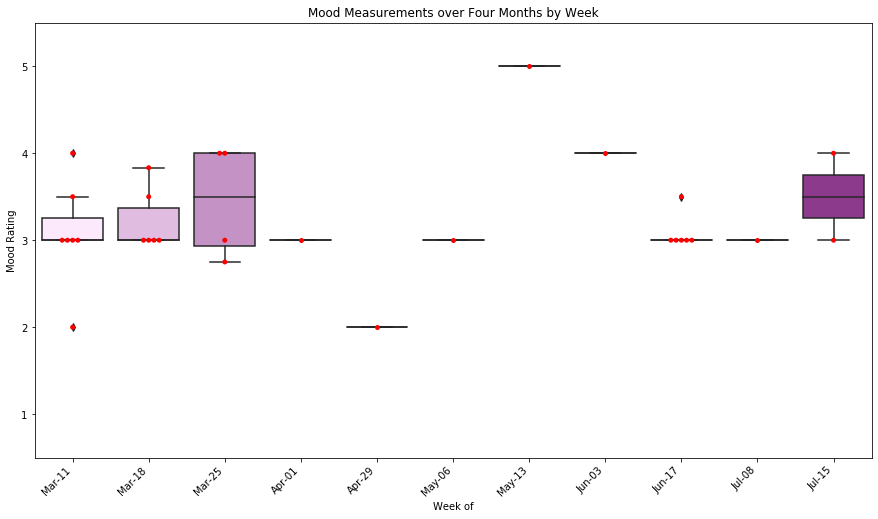

In [672]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=mood_week, ax=ax, palette=sns.light_palette("purple"))
fig = sns.swarmplot(x="date", y="value", data=mood_week, color="red", edgecolor="grey")

x_dates = mood_week['date'].dt.strftime('%b-%d').unique()
ax.set(title="Mood Measurements over Four Months by Week")
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='Week of', ylabel='Mood Rating')
ax.set(ylim=(0.5, 5.5))

[(0.5, 5.5)]

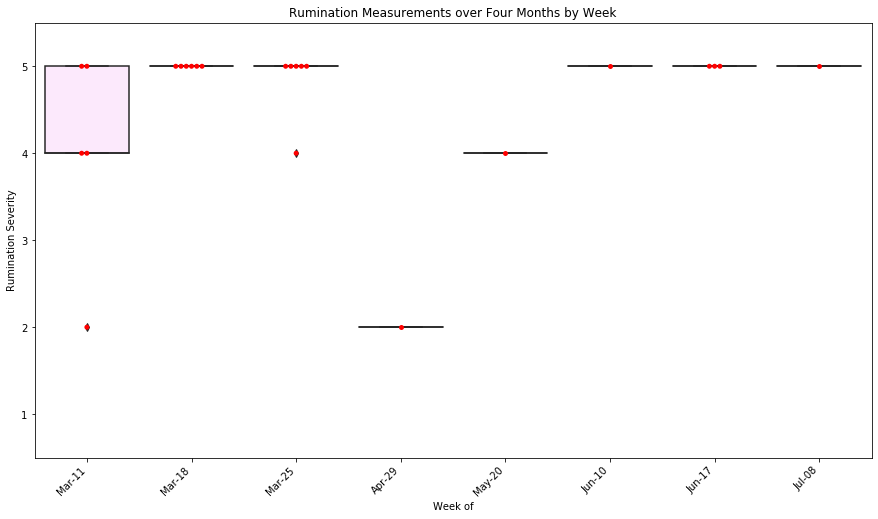

In [673]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=rum_week, ax=ax, palette=sns.light_palette("purple"))
fig = sns.swarmplot(x="date", y="value", data=rum_week, color="red", edgecolor="grey")

x_dates = rum_week['date'].dt.strftime('%b-%d').unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(title="Rumination Measurements over Four Months by Week")
ax.set(xlabel='Week of', ylabel='Rumination Severity')
ax.set(ylim=(0.5, 5.5))

[(0.5, 5.5)]

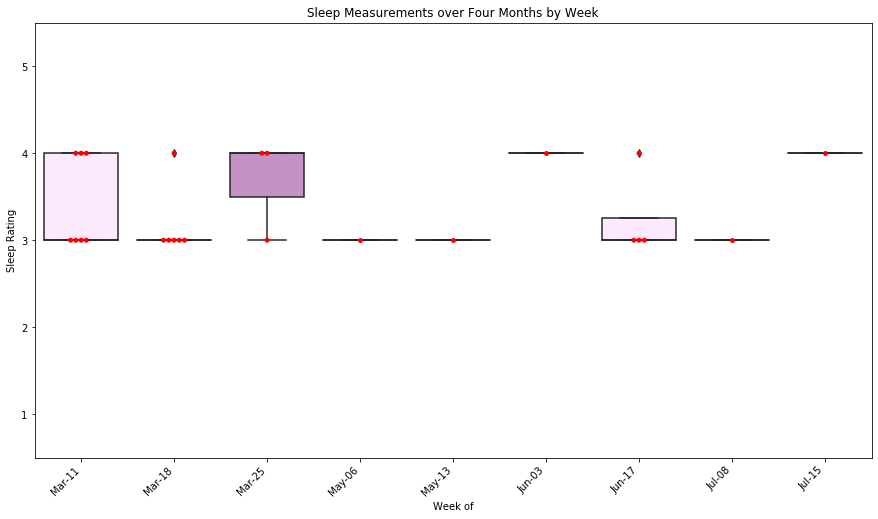

In [674]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=sleep_week, ax=ax, palette=sns.light_palette("purple"))
fig = sns.swarmplot(x="date", y="value", data=sleep_week, color="red", edgecolor="grey")

x_dates = sleep_week['date'].dt.strftime('%b-%d').unique()
ax.set(title="Sleep Measurements over Four Months by Week")
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='Week of', ylabel='Sleep Rating')
ax.set(ylim=(0.5, 5.5))

[(0.5, 5.5)]

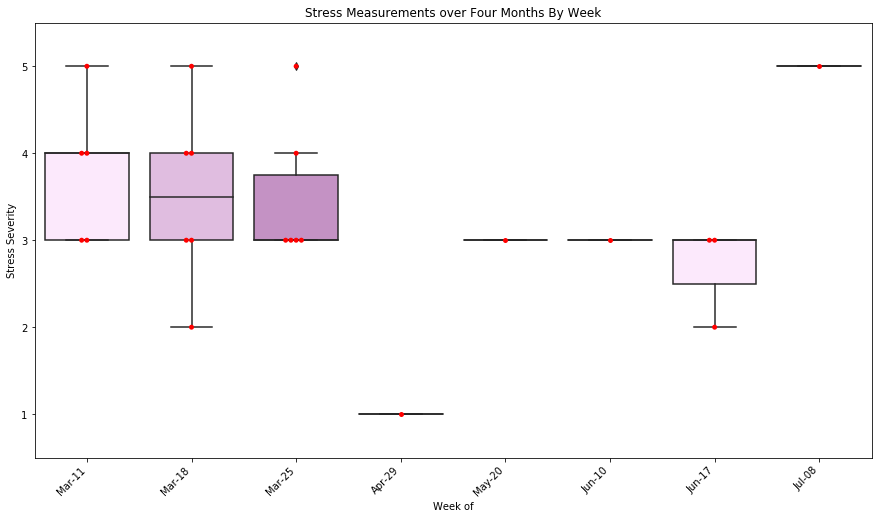

In [675]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=stress_week, ax=ax, palette=sns.light_palette("purple"))
fig = sns.swarmplot(x="date", y="value", data=stress_week, color="red", edgecolor="grey")

x_dates = stress_week['date'].dt.strftime('%b-%d').unique()
ax.set(title="Stress Measurements over Four Months By Week")
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='Week of', ylabel='Stress Severity')
ax.set(ylim=(0.5, 5.5))

By plotting the data by week using a box plot/swarm plot, we get an distributed view of the each log entry every week. Unfortunately, it looks like there is very few data points from the first week of April to the first week of June. Furthermore, the weeks the patient did not enter data are omitted (May 20th, May 27th, June 10th, June 23rd). However, The single data points from April to June suggest improvement in mood, rumination, and stress. 

This finding leads me to have a hypothesis. For this particular dataset, if the patient is feeling well, they will not use the app as often. To test, we will need to experiment with the app on healthy patients and compare usage patterns between healthy users and patients.

Because of the lack of data in some weeks, let's now take a look at the monthly value distributions to visualize and determine monthly progress.

In [676]:
mood_month = mood_day.groupby(pd.Grouper(key='date', freq='M')).apply(lambda x: x['value']).reset_index()
del mood_month['level_1']

rum_month = rum_day.groupby(pd.Grouper(key='date', freq='M')).apply(lambda x: x['value']).reset_index()
del rum_month['level_1']

sleep_month = sleep_day.groupby(pd.Grouper(key='date', freq='M')).apply(lambda x: x['value']).reset_index()
del sleep_month['level_1']

stress_month = stress_day.groupby(pd.Grouper(key='date', freq='M')).apply(lambda x: x['value']).reset_index()
del stress_month['level_1']

mood_month.head()

,date,value
0,2018-03-31,3.0
1,2018-03-31,3.0
2,2018-03-31,3.0
3,2018-03-31,2.0
4,2018-03-31,3.0


[(0.5, 5.5)]

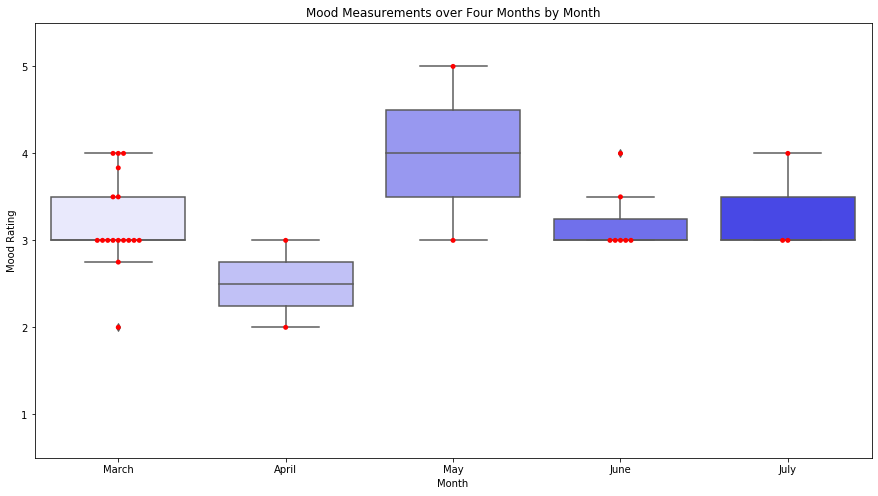

In [677]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=mood_month, ax=ax, palette=sns.light_palette("blue"))
fig = sns.swarmplot(x="date", y="value", data=mood_month, color="red", edgecolor="grey")

x_dates = mood_month['date'].dt.strftime('%B').unique()
ax.set(title="Mood Measurements over Four Months by Month")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Month', ylabel='Mood Rating')
ax.set(ylim=(0.5, 5.5))

In the monthly analysis for mood, no progress is really seen. Especially, the data from April and May are scarce and do not hold as much weight as the March data. Similarly:

[(0.5, 5.5)]

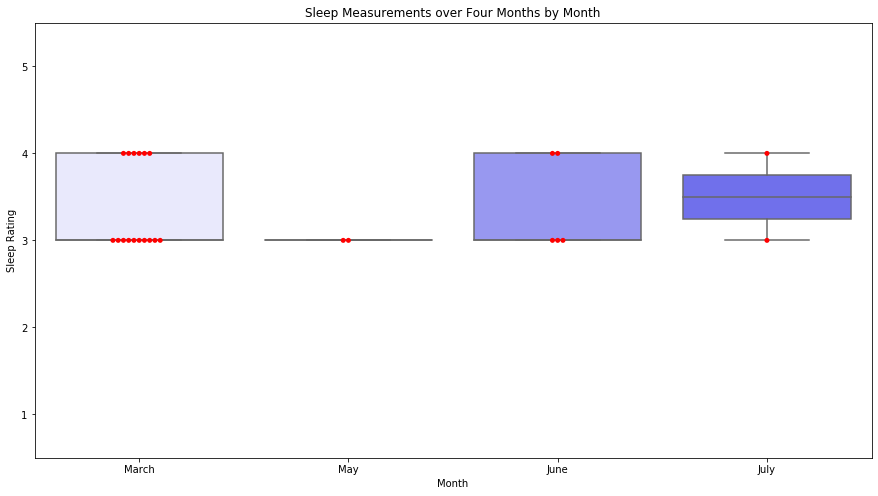

In [678]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=sleep_month, ax=ax, palette=sns.light_palette("blue"))
fig = sns.swarmplot(x="date", y="value", data=sleep_month, color="red", edgecolor="grey")

x_dates = sleep_month['date'].dt.strftime('%B').unique()
ax.set(title="Sleep Measurements over Four Months by Month")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Month', ylabel='Sleep Rating')
ax.set(ylim=(0.5, 5.5))

[(0.5, 5.5)]

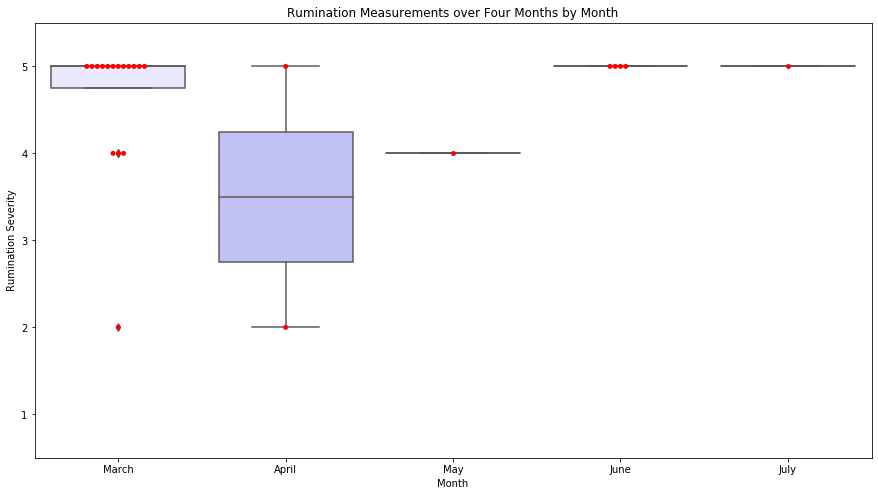

In [679]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=rum_month, ax=ax, palette=sns.light_palette("blue"))
fig = sns.swarmplot(x="date", y="value", data=rum_month, color="red", edgecolor="grey")

x_dates = rum_month['date'].dt.strftime('%B').unique()
ax.set(title="Rumination Measurements over Four Months by Month")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Month', ylabel='Rumination Severity')
ax.set(ylim=(0.5, 5.5))

Simply put, the skewedness of the data towards March makes tracking monthly progress difficult.

[(0.5, 5.5)]

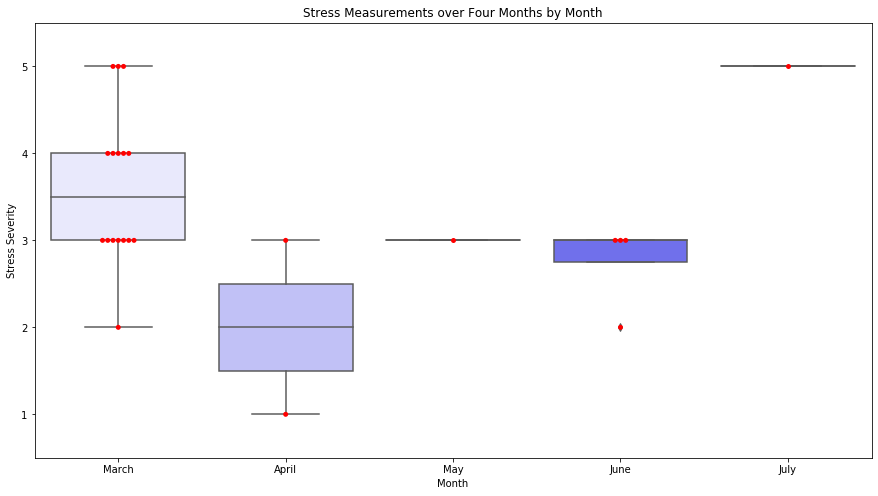

In [680]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="date", y="value", data=stress_month, ax=ax, palette=sns.light_palette("blue"))
fig = sns.swarmplot(x="date", y="value", data=stress_month, color="red", edgecolor="grey")

x_dates = stress_month['date'].dt.strftime('%B').unique()
ax.set(title="Stress Measurements over Four Months by Month")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Month', ylabel='Stress Severity')
ax.set(ylim=(0.5, 5.5))

Once again, the lack of data points in April, May, and July makes the data difficult to analyze, but it seems like the stress was highest during the month of March and has seen improvement since.

### Supplementary Data Analysis

The patient progress analysis ignored the multiple entries that may happen during the day. I had several lingering questions:
- When in the day does the patient usually log a measurement? 
- How does a person's measurements change over the day?


To explore the first question, let's use a histogram on the number of logs per hour.

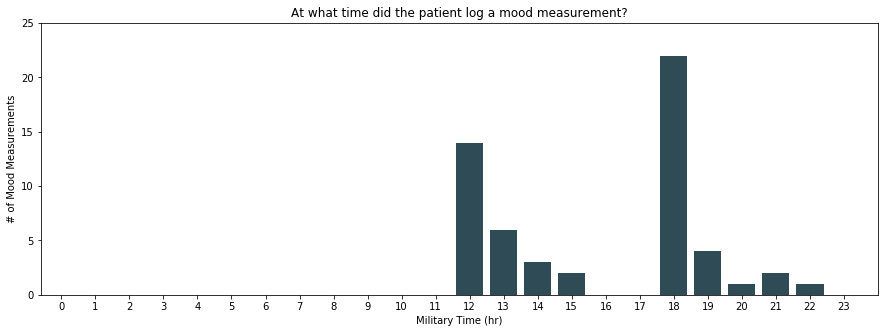

In [681]:
plt.figure(figsize=(15,5))
plt.hist([t.hour for t in mood['date']], bins = np.arange(24)-0.5, rwidth = 0.8)
plt.xticks(np.arange(0,24 , step=1))
plt.xlabel('Military Time (hr)')
plt.ylabel('# of Mood Measurements')
plt.title('At what time did the patient log a mood measurement?')
plt.axis([-0.6, 24, 0, 25])

plt.show()


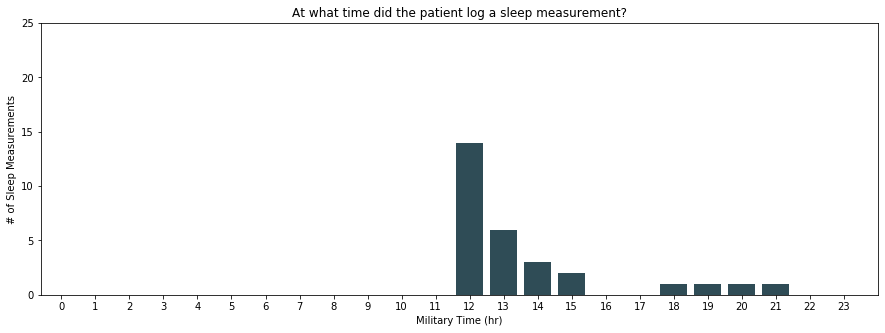

In [682]:
plt.figure(figsize=(15,5))
plt.hist([t.hour for t in sleep['date']], bins = np.arange(24)-0.5, rwidth = 0.8)
plt.xticks(np.arange(0,24 , step=1))
plt.xlabel('Military Time (hr)')
plt.ylabel('# of Sleep Measurements')
plt.title('At what time did the patient log a sleep measurement?')
plt.axis([-0.6, 24, 0, 25])

plt.show()

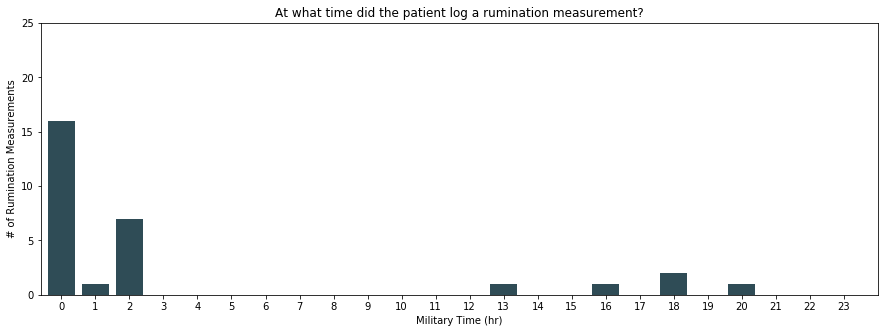

In [683]:
plt.figure(figsize=(15,5))
plt.hist([t.hour for t in rumination['date']], bins = np.arange(24)-0.5, rwidth = 0.8)
plt.xticks(np.arange(0,24 , step=1))
plt.xlabel('Military Time (hr)')
plt.ylabel('# of Rumination Measurements')
plt.title('At what time did the patient log a rumination measurement?')
plt.axis([-0.6, 24, 0, 25])

plt.show()

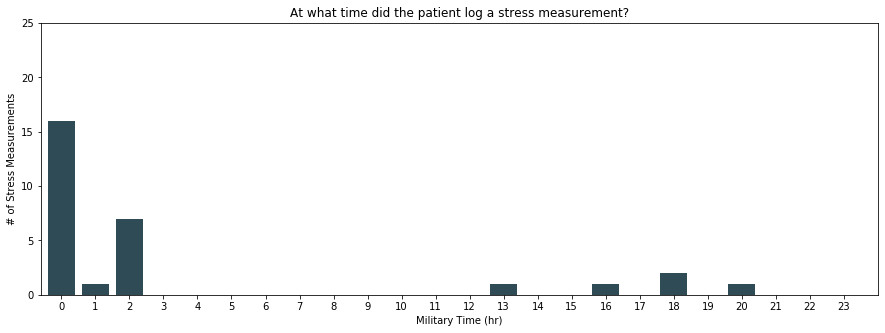

In [684]:
plt.figure(figsize=(15,5))
plt.hist([t.hour for t in stress['date']], bins = np.arange(24)-0.5, rwidth = 0.8)
plt.xticks(np.arange(0,24 , step=1))
plt.xlabel('Military Time (hr)')
plt.ylabel('# of Stress Measurements')
plt.title('At what time did the patient log a stress measurement?')
plt.axis([-0.6, 24, 0, 25])

plt.show()

Interesting, for the mood and sleep measurements, they usually occur after noon, while the stress and rumination measurements seem to occur from midnight to around 2 am. Let's take a look at the ratings at each of the time periods

In [685]:
group_date = [dt.datetime.strftime(e, '%H') for e in mood['date']]
mood_hour = mood.groupby(group_date).apply(lambda x: x['value']).reset_index()
del mood_hour['level_1']
mood_hour = mood_hour.rename(index=str, columns={"level_0": "hour", "value": "value"})

group_date2 = [dt.datetime.strftime(e, '%H') for e in sleep['date']]
sleep_hour = sleep.groupby(group_date2).apply(lambda x: x['value']).reset_index()
del sleep_hour['level_1']
sleep_hour = sleep_hour.rename(index=str, columns={"level_0": "hour", "value": "value"})

group_date3 = [dt.datetime.strftime(e, '%H') for e in rumination['date']]
rum_hour = rumination.groupby(group_date3).apply(lambda x: x['value']).reset_index()
del rum_hour['level_1']
rum_hour = rum_hour.rename(index=str, columns={"level_0": "hour", "value": "value"})

group_date4 = [dt.datetime.strftime(e, '%H') for e in stress['date']]
stress_hour = stress.groupby(group_date4).apply(lambda x: x['value']).reset_index()
del stress_hour['level_1']
stress_hour = stress_hour.rename(index=str, columns={"level_0": "hour", "value": "value"})


[(0.5, 5.5)]

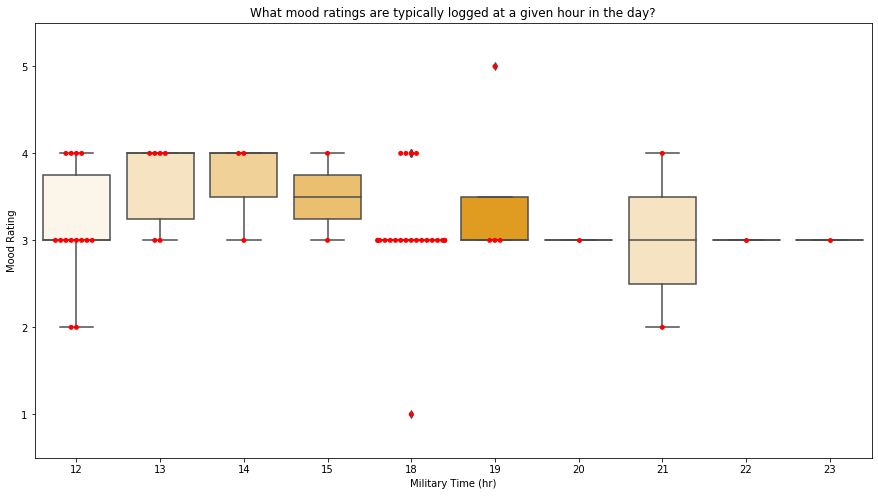

In [686]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="hour", y="value", data=mood_hour, ax=ax, palette=sns.light_palette("orange"))
fig = sns.swarmplot(x="hour", y="value", data=mood_hour, color="red", edgecolor="grey")

x_dates = mood_hour['hour'].unique()
ax.set(title="What mood ratings are typically logged at a given hour in the day?")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Military Time (hr)', ylabel='Mood Rating')
ax.set(ylim=(0.5, 5.5))

[(0.5, 5.5)]

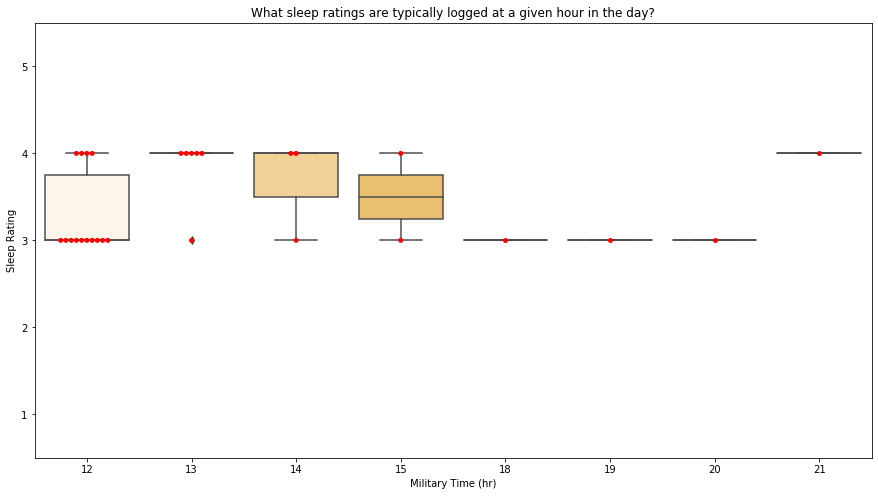

In [687]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="hour", y="value", data=sleep_hour, ax=ax, palette=sns.light_palette("orange"))
fig = sns.swarmplot(x="hour", y="value", data=sleep_hour, color="red", edgecolor="grey")

x_dates = sleep_hour['hour'].unique()
ax.set(title="What sleep ratings are typically logged at a given hour in the day?")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Military Time (hr)', ylabel='Sleep Rating')
ax.set(ylim=(0.5, 5.5))

For mood and sleep, there doesn't seem to be too much variation in the ratings for a given hour. However the data show that the notification at 8am is not necessarily effective as the patients usually logs after noon.

[(0.5, 5.5)]

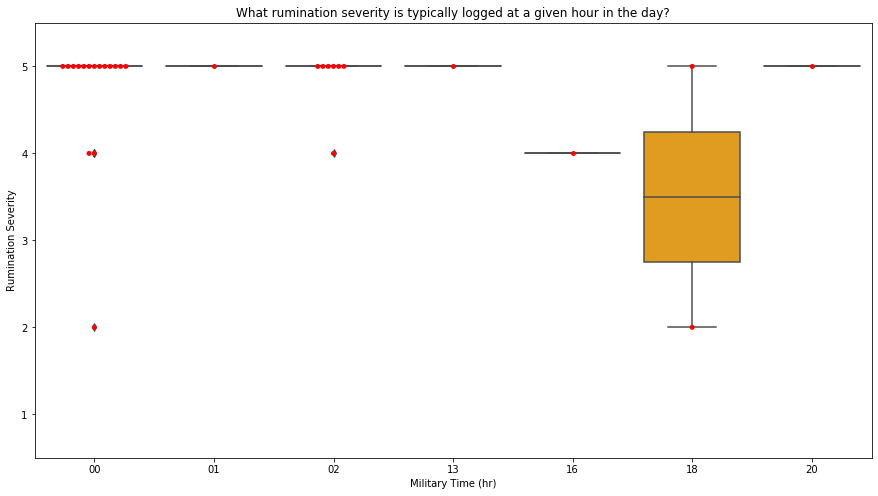

In [688]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="hour", y="value", data=rum_hour, ax=ax, palette=sns.light_palette("orange"))
fig = sns.swarmplot(x="hour", y="value", data=rum_hour, color="red", edgecolor="grey")

x_dates = rum_hour['hour'].unique()
ax.set(title="What rumination severity is typically logged at a given hour in the day?")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Military Time (hr)', ylabel='Rumination Severity')
ax.set(ylim=(0.5, 5.5))

[(0.5, 5.5)]

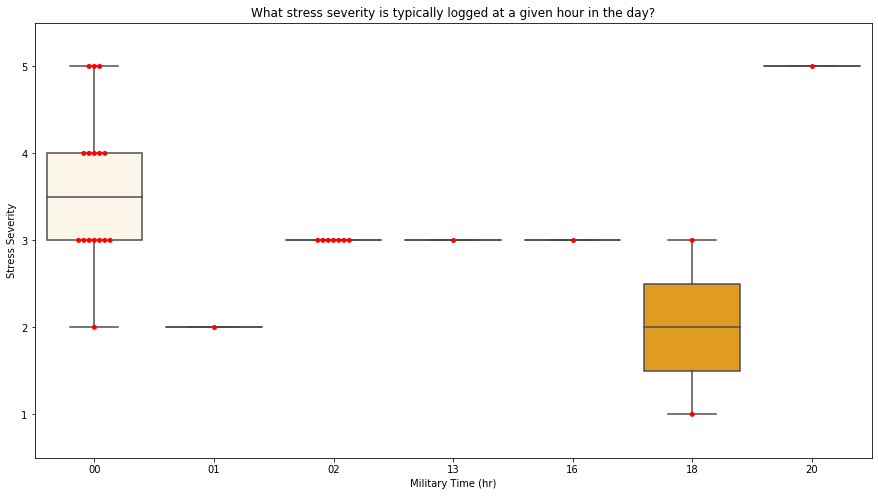

In [689]:
fig, ax = plt.subplots(figsize = (15,8))
fig = sns.boxplot(x="hour", y="value", data=stress_hour, ax=ax, palette=sns.light_palette("orange"))
fig = sns.swarmplot(x="hour", y="value", data=stress_hour, color="red", edgecolor="grey")

x_dates = stress_hour['hour'].unique()
ax.set(title="What stress severity is typically logged at a given hour in the day?")
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.set(xlabel='Military Time (hr)', ylabel='Stress Severity')
ax.set(ylim=(0.5, 5.5))

As we predicted, the rumination and stress severity seems to be the highest when it is recorded at midnight, 1 am, and 2 am. A sign of progress may mean less entries past midnight for rumination and stress. 

 ### Conclusion

Using the four metrics, we were able to uncover findings both in patient progress and behaviors in daily logging usage. 

#### Patient Progress
Unfortunately, the relationships in the progress data were not too strong, due to the amount of data that is available. However, from our exploratory analysis, I hypothesize that the might exist a relationship between frequency of app usage and wellness in the four areas, noting the lack of data from April to June.

#### Supplementary findings
We resolved our hunch that higher stress and rumination logging occurs in the late hours, and perhaps progress can be seen if this type of logging decreases.

#### Future
There needs to be further analysis in:

1. Display the number of rumination and stress logging after midnight for each month to track the progress of the patient
2. Correlational relationships between the four measurements (is stress related to sleep quality?)
3. For the app itself, additional measurements could be taken for appetite (shown to be related to depression), time in which medication was take, amount of hours slept (may be more objective than subjective sleep), and also time of taking medication (some medication is periodic and placebo effects may occur.